<a href="https://colab.research.google.com/github/Deepak-kumar2004/Deep-Learning-Sem-5/blob/main/Autoencoder_%26_PCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PCA

In [1]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from tensorflow.keras.datasets import fashion_mnist  # or tf_keras.datasets.fashion_mnist


29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

===== PCA with 2 components =====
Test reconstruction MSE (k=2): 0.046096

===== PCA with 8 components =====
Test reconstruction MSE (k=8): 0.026607

===== PCA with 16 components =====
Test reconstruction MSE (k=16): 0.020446

===== PCA with 32 components =====
Test reconstruction MSE (k=32): 0.015142

===== PCA with 64 components =====
Test reconstruction MSE (k=64): 0.010368

===== PCA with 128 components =====
Test reconstruction MSE (k=128): 0.006312


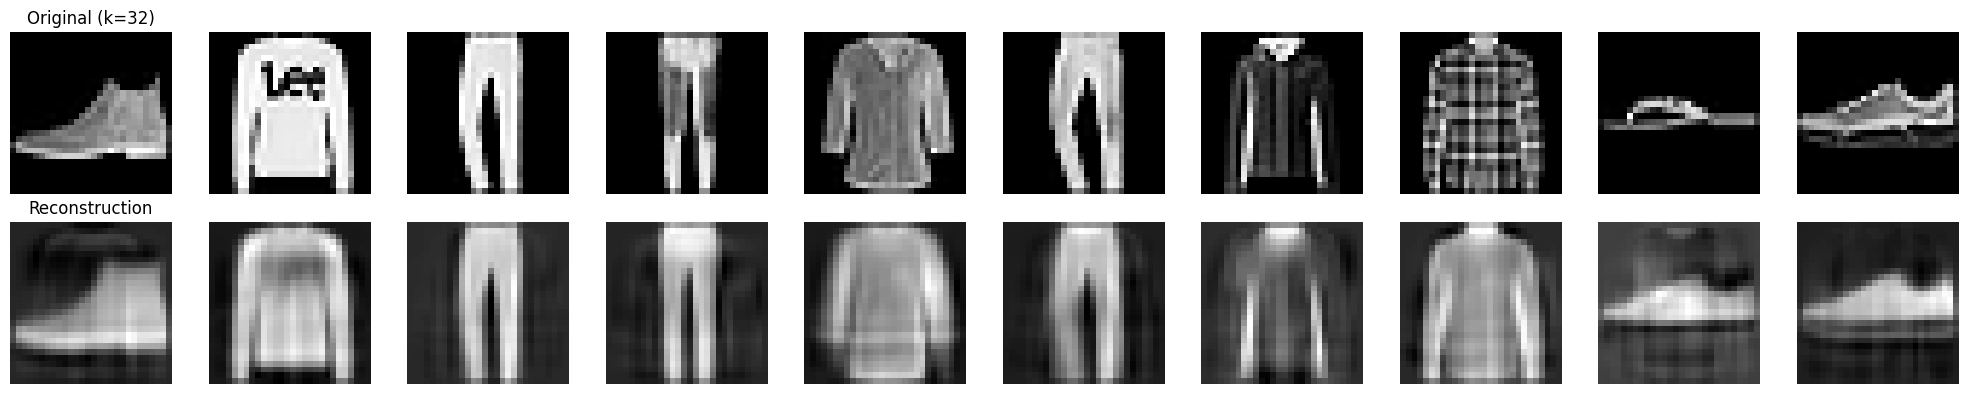

In [2]:

# 1. Load Fashion-MNIST
# Shapes: x_train (60000, 28, 28), x_test (10000, 28, 28) [web:219]
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# 2. Normalize to [0,1] and flatten to vectors of length 784
x_train = x_train.astype("float32") / 255.0
x_test  = x_test.astype("float32") / 255.0

n_train, h, w = x_train.shape
n_test,  _, _ = x_test.shape
input_dim = h * w  # 28 * 28 = 784

x_train_flat = x_train.reshape(n_train, input_dim)
x_test_flat  = x_test.reshape(n_test,  input_dim)

# 3. Function to run PCA, reconstruct, and compute reconstruction error
def run_pca_and_reconstruct(x_train_flat, x_test_flat, n_components):
    """
    Fit PCA on train set with n_components, reconstruct train and test,
    and return reconstructed arrays + MSE on test set.
    """
    pca = PCA(n_components=n_components, random_state=42)  # sklearn centers data internally [web:220]
    pca.fit(x_train_flat)

    # Transform to latent space
    z_train = pca.transform(x_train_flat)
    z_test  = pca.transform(x_test_flat)

    # Reconstruct back to original space
    x_train_recon = pca.inverse_transform(z_train)
    x_test_recon  = pca.inverse_transform(z_test)

    # Compute reconstruction error (MSE) on test set
    mse_test = mean_squared_error(x_test_flat, x_test_recon)

    return x_train_recon, x_test_recon, mse_test, pca

# 4. Evaluate PCA for multiple latent dimensions
latent_dims = [2, 8, 16, 32, 64, 128]
results = {}

for k in latent_dims:
    print(f"\n===== PCA with {k} components =====")
    x_train_recon, x_test_recon, mse_test, pca_model = run_pca_and_reconstruct(
        x_train_flat, x_test_flat, n_components=k
    )
    results[k] = {
        "mse_test": mse_test,
        "pca_model": pca_model,
        "x_test_recon": x_test_recon,  # keep some reconstructions for visualization
    }
    print(f"Test reconstruction MSE (k={k}): {mse_test:.6f}")

# 5. Optional: visualize a few original vs reconstructed images for a given k
import matplotlib.pyplot as plt

def show_reconstructions(k, num_examples=10):
    """
    Show original and reconstructed images side by side for a given k.
    """
    x_test_recon = results[k]["x_test_recon"]
    # pick first num_examples
    orig = x_test_flat[:num_examples].reshape(num_examples, h, w)
    recon = x_test_recon[:num_examples].reshape(num_examples, h, w)

    plt.figure(figsize=(2 * num_examples, 4))
    for i in range(num_examples):
        # original
        ax = plt.subplot(2, num_examples, i + 1)
        plt.imshow(orig[i], cmap="gray")
        plt.axis("off")
        if i == 0:
            ax.set_title(f"Original (k={k})")

        # reconstruction
        ax = plt.subplot(2, num_examples, i + 1 + num_examples)
        plt.imshow(recon[i], cmap="gray")
        plt.axis("off")
        if i == 0:
            ax.set_title("Reconstruction")

    plt.tight_layout()
    plt.show()

# Example: visualize reconstructions for k = 32
show_reconstructions(k=32, num_examples=10)


# Autoencoder

In [3]:
"""
Autoencoder for Fashion-MNIST Dimensionality Reduction
Matches PCA setup for direct comparison
"""

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import time

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)


# =============================================================================
# 1. LOAD AND PREPROCESS DATA (same as PCA)
# =============================================================================

print("Loading Fashion-MNIST dataset...")
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Normalize to [0,1] range
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

# Flatten to vectors (784,)
n_train, h, w = x_train.shape
n_test, _, _ = x_test.shape
input_dim = h * w  # 784

x_train_flat = x_train.reshape(n_train, input_dim)
x_test_flat = x_test.reshape(n_test, input_dim)

print(f"Training samples: {n_train}, Test samples: {n_test}")
print(f"Input dimension: {input_dim}")


Loading Fashion-MNIST dataset...
Training samples: 60000, Test samples: 10000
Input dimension: 784


In [4]:
# =============================================================================
# 2. AUTOENCODER ARCHITECTURE
# =============================================================================

class DenseAutoencoder(Model):
    """
    Fully connected autoencoder for dimensionality reduction
    Architecture: Input -> Dense(512) -> Dense(256) -> Bottleneck(latent_dim)
                  -> Dense(256) -> Dense(512) -> Output(784)
    """
    def __init__(self, latent_dim, input_dim=784):
        super(DenseAutoencoder, self).__init__()
        self.latent_dim = latent_dim
        self.input_dim = input_dim

        # Encoder
        self.encoder = keras.Sequential([
            layers.InputLayer(input_shape=(input_dim,)),
            layers.Dense(512, activation='relu', name='encoder_dense1'),
            layers.Dense(256, activation='relu', name='encoder_dense2'),
            layers.Dense(latent_dim, activation='relu', name='latent_space')
        ], name='encoder')

        # Decoder
        self.decoder = keras.Sequential([
            layers.InputLayer(input_shape=(latent_dim,)),
            layers.Dense(256, activation='relu', name='decoder_dense1'),
            layers.Dense(512, activation='relu', name='decoder_dense2'),
            layers.Dense(input_dim, activation='sigmoid', name='output')  # sigmoid for [0,1] output
        ], name='decoder')

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

    def encode(self, x):
        """Get latent representation"""
        return self.encoder(x)

    def decode(self, z):
        """Reconstruct from latent representation"""
        return self.decoder(z)


In [5]:
# =============================================================================
# 3. HYPERPARAMETERS
# =============================================================================

HYPERPARAMETERS = {
    'latent_dims': [2, 8, 16, 32, 64, 128],  # Match PCA components
    'learning_rate': 0.001,  # Adam default
    'batch_size': 128,
    'epochs': 100,
    'patience': 10,  # For early stopping
    'validation_split': 0.1
}

# Alternative hyperparameters to test
ALTERNATIVE_CONFIGS = {
    'low_lr': {'learning_rate': 0.0001, 'batch_size': 128},
    'high_lr': {'learning_rate': 0.01, 'batch_size': 128},
    'large_batch': {'learning_rate': 0.001, 'batch_size': 256},
    'small_batch': {'learning_rate': 0.001, 'batch_size': 32},
}



In [6]:
# =============================================================================
# 4. TRAINING FUNCTION
# =============================================================================

def train_autoencoder(latent_dim, x_train, x_test,
                      learning_rate=0.001,
                      batch_size=128,
                      epochs=100,
                      patience=10,
                      validation_split=0.1,
                      verbose=1):
    """
    Train autoencoder with specified hyperparameters
    Returns: trained model, history, training time
    """
    print(f"\n{'='*60}")
    print(f"Training Autoencoder with latent_dim={latent_dim}")
    print(f"{'='*60}")

    # Build model
    autoencoder = DenseAutoencoder(latent_dim=latent_dim, input_dim=input_dim)

    # Compile with MSE loss (same metric as PCA for fair comparison)
    autoencoder.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss='mse',  # Mean Squared Error
        metrics=['mse']
    )

    # Callbacks
    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=patience,
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-7,
            verbose=1
        )
    ]

    # Train
    start_time = time.time()
    history = autoencoder.fit(
        x_train, x_train,  # Input = Output for autoencoder
        epochs=epochs,
        batch_size=batch_size,
        validation_split=validation_split,
        callbacks=callbacks,
        verbose=verbose
    )
    training_time = time.time() - start_time

    print(f"\nTraining completed in {training_time:.2f} seconds")

    return autoencoder, history, training_time



In [7]:
# =============================================================================
# 5. EVALUATION FUNCTION
# =============================================================================

def evaluate_autoencoder(autoencoder, x_test, latent_dim):
    """
    Evaluate autoencoder reconstruction quality
    Returns: test MSE, RMSE, reconstructed images
    """
    # Encode and decode test set
    x_test_recon = autoencoder.predict(x_test, verbose=0)

    # Compute reconstruction metrics
    mse_test = mean_squared_error(x_test, x_test_recon)
    rmse_test = np.sqrt(mse_test)

    print(f"\nTest Reconstruction Metrics (k={latent_dim}):")
    print(f"  MSE:  {mse_test:.6f}")
    print(f"  RMSE: {rmse_test:.6f}")

    return mse_test, rmse_test, x_test_recon



In [8]:
# =============================================================================
# 6. RUN EXPERIMENTS
# =============================================================================

results = {}

for latent_dim in HYPERPARAMETERS['latent_dims']:
    # Train autoencoder
    autoencoder, history, training_time = train_autoencoder(
        latent_dim=latent_dim,
        x_train=x_train_flat,
        x_test=x_test_flat,
        learning_rate=HYPERPARAMETERS['learning_rate'],
        batch_size=HYPERPARAMETERS['batch_size'],
        epochs=HYPERPARAMETERS['epochs'],
        patience=HYPERPARAMETERS['patience'],
        validation_split=HYPERPARAMETERS['validation_split'],
        verbose=1
    )

    # Evaluate
    mse_test, rmse_test, x_test_recon = evaluate_autoencoder(
        autoencoder, x_test_flat, latent_dim
    )

    # Store results
    results[latent_dim] = {
        'model': autoencoder,
        'history': history,
        'mse_test': mse_test,
        'rmse_test': rmse_test,
        'training_time': training_time,
        'x_test_recon': x_test_recon
    }

    # Save model weights
    autoencoder.save_weights(f'autoencoder_latent{latent_dim}.weights.h5')
    print(f"Model weights saved to: autoencoder_latent{latent_dim}.weights.h5")




Training Autoencoder with latent_dim=2


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 0.0658 - mse: 0.0658 - val_loss: 0.0352 - val_mse: 0.0352 - learning_rate: 0.0010
Epoch 2/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0335 - mse: 0.0335 - val_loss: 0.0317 - val_mse: 0.0317 - learning_rate: 0.0010
Epoch 3/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0306 - mse: 0.0306 - val_loss: 0.0302 - val_mse: 0.0302 - learning_rate: 0.0010
Epoch 4/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0296 - mse: 0.0296 - val_loss: 0.0294 - val_mse: 0.0294 - learning_rate: 0.0010
Epoch 5/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0289 - mse: 0.0289 - val_loss: 0.0289 - val_mse: 0.0289 - learning_rate: 0.0010
Epoch 6/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0283 - mse: 0.0283 - val_loss: 0.0285 - val_mse: 0.0285 - learning_rate: 0.0010
Epoch 7/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0279 - mse: 0.0279 - val_loss: 0.0283 - val_mse: 0.0283 - learning_rate: 0.0010

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0546 - mse: 0.0546 - val_loss: 0.0210 - val_mse: 0.0210 - learning_rate: 0.0010
Epoch 2/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0200 - mse: 0.0200 - val_loss: 0.0181 - val_mse: 0.0181 - learning_rate: 0.0010
Epoch 3/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0177 - mse: 0.0177 - val_loss: 0.0171 - val_mse: 0.0171 - learning_rate: 0.0010
Epoch 4/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0167 - mse: 0.0167 - val_loss: 0.0161 - val_mse: 0.0161 - learning_rate: 0.0010
Epoch 5/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0159 - mse: 0.0159 - val_loss: 0.0155 - val_mse: 0.0155 - learning_rate: 0.0010
Epoch 6/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0153 - mse: 0.0153 - val_loss: 0.0151 - val_mse: 0.0151 - learning_rate: 0.0010
Epoch 7/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0149 - mse: 0.0149 - val_loss: 0.0148 - val_mse: 0.0148 - learning_rate: 0.0010

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0552 - mse: 0.0552 - val_loss: 0.0196 - val_mse: 0.0196 - learning_rate: 0.0010
Epoch 2/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0185 - mse: 0.0185 - val_loss: 0.0164 - val_mse: 0.0164 - learning_rate: 0.0010
Epoch 3/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0160 - mse: 0.0160 - val_loss: 0.0150 - val_mse: 0.0150 - learning_rate: 0.0010
Epoch 4/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0148 - mse: 0.0148 - val_loss: 0.0143 - val_mse: 0.0143 - learning_rate: 0.0010
Epoch 5/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0141 - mse: 0.0141 - val_loss: 0.0139 - val_mse: 0.0139 - learning_rate: 0.0010
Epoch 6/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0136 - mse: 0.0136 - val_loss: 0.0135 - val_mse: 0.0135 - learning_rate: 0.0010
Epoch 7/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0133 - mse: 0.0133 - val_loss: 0.0134 - val_mse: 0.0134 - learning_rate: 0.0010

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0500 - mse: 0.0500 - val_loss: 0.0181 - val_mse: 0.0181 - learning_rate: 0.0010
Epoch 2/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0172 - mse: 0.0172 - val_loss: 0.0147 - val_mse: 0.0147 - learning_rate: 0.0010
Epoch 3/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0142 - mse: 0.0142 - val_loss: 0.0130 - val_mse: 0.0130 - learning_rate: 0.0010
Epoch 4/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0126 - mse: 0.0126 - val_loss: 0.0120 - val_mse: 0.0120 - learning_rate: 0.0010
Epoch 5/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0117 - mse: 0.0117 - val_loss: 0.0113 - val_mse: 0.0113 - learning_rate: 0.0010
Epoch 6/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0111 - mse: 0.0111 - val_loss: 0.0111 - val_mse: 0.0111 - learning_rate: 0.0010
Epoch 7/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0106 - mse: 0.0106 - val_loss: 0.0105 - val_mse: 0.0105 - learning_rate: 0.0010

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0499 - mse: 0.0499 - val_loss: 0.0182 - val_mse: 0.0182 - learning_rate: 0.0010
Epoch 2/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0170 - mse: 0.0170 - val_loss: 0.0144 - val_mse: 0.0144 - learning_rate: 0.0010
Epoch 3/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0137 - mse: 0.0137 - val_loss: 0.0124 - val_mse: 0.0124 - learning_rate: 0.0010
Epoch 4/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0121 - mse: 0.0121 - val_loss: 0.0114 - val_mse: 0.0114 - learning_rate: 0.0010
Epoch 5/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0111 - mse: 0.0111 - val_loss: 0.0107 - val_mse: 0.0107 - learning_rate: 0.0010
Epoch 6/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0103 - mse: 0.0103 - val_loss: 0.0102 - val_mse: 0.0102 - learning_rate: 0.0010
Epoch 7/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0099 - mse: 0.0099 - val_loss: 0.0101 - val_mse: 0.0101 - learning_rate: 0.0010

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0497 - mse: 0.0497 - val_loss: 0.0175 - val_mse: 0.0175 - learning_rate: 0.0010
Epoch 2/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0164 - mse: 0.0164 - val_loss: 0.0138 - val_mse: 0.0138 - learning_rate: 0.0010
Epoch 3/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0132 - mse: 0.0132 - val_loss: 0.0120 - val_mse: 0.0120 - learning_rate: 0.0010
Epoch 4/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0115 - mse: 0.0115 - val_loss: 0.0109 - val_mse: 0.0109 - learning_rate: 0.0010
Epoch 5/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0105 - mse: 0.0105 - val_loss: 0.0099 - val_mse: 0.0099 - learning_rate: 0.0010
Epoch 6/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0098 - mse: 0.0098 - val_loss: 0.0095 - val_mse: 0.0095 - learning_rate: 0.0010
Epoch 7/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0093 - mse: 0.0093 - val_loss: 0.0091 - val_mse: 0.0091 - learning_rate: 0.0010

In [9]:
# =============================================================================
# 7. VISUALIZATION FUNCTIONS
# =============================================================================

def plot_training_history(results, latent_dims):
    """Plot training and validation loss curves"""
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    axes = axes.flatten()

    for idx, latent_dim in enumerate(latent_dims):
        history = results[latent_dim]['history']
        ax = axes[idx]

        ax.plot(history.history['loss'], label='Train Loss', linewidth=2)
        ax.plot(history.history['val_loss'], label='Val Loss', linewidth=2)
        ax.set_xlabel('Epoch', fontsize=10)
        ax.set_ylabel('MSE Loss', fontsize=10)
        ax.set_title(f'Latent Dim = {latent_dim}', fontsize=12, fontweight='bold')
        ax.legend()
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('autoencoder_training_curves.png', dpi=300, bbox_inches='tight')
    plt.show()

def show_reconstructions(results, latent_dim, num_examples=10):
    """Display original vs reconstructed images"""
    x_test_recon = results[latent_dim]['x_test_recon']

    orig = x_test_flat[:num_examples].reshape(num_examples, h, w)
    recon = x_test_recon[:num_examples].reshape(num_examples, h, w)

    fig = plt.figure(figsize=(num_examples * 2, 4))
    for i in range(num_examples):
        # Original
        ax = plt.subplot(2, num_examples, i + 1)
        plt.imshow(orig[i], cmap='gray', vmin=0, vmax=1)
        plt.axis('off')
        if i == 0:
            ax.set_title(f'Original\n(k={latent_dim})', fontsize=10, fontweight='bold')

        # Reconstruction
        ax = plt.subplot(2, num_examples, i + 1 + num_examples)
        plt.imshow(recon[i], cmap='gray', vmin=0, vmax=1)
        plt.axis('off')
        if i == 0:
            ax.set_title('Reconstructed', fontsize=10, fontweight='bold')

    plt.tight_layout()
    plt.savefig(f'autoencoder_reconstruction_k{latent_dim}.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_reconstruction_error_comparison(results, latent_dims):
    """Plot reconstruction error vs latent dimension"""
    mse_values = [results[k]['mse_test'] for k in latent_dims]
    rmse_values = [results[k]['rmse_test'] for k in latent_dims]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # MSE plot
    ax1.plot(latent_dims, mse_values, marker='o', linewidth=2, markersize=8, color='#2E86AB')
    ax1.set_xlabel('Latent Dimension (k)', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Test MSE', fontsize=12, fontweight='bold')
    ax1.set_title('Reconstruction Error (MSE)', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.set_xscale('log', base=2)

    # RMSE plot
    ax2.plot(latent_dims, rmse_values, marker='s', linewidth=2, markersize=8, color='#A23B72')
    ax2.set_xlabel('Latent Dimension (k)', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Test RMSE', fontsize=12, fontweight='bold')
    ax2.set_title('Reconstruction Error (RMSE)', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    ax2.set_xscale('log', base=2)

    plt.tight_layout()
    plt.savefig('autoencoder_error_vs_latent_dim.png', dpi=300, bbox_inches='tight')
    plt.show()




GENERATING VISUALIZATIONS


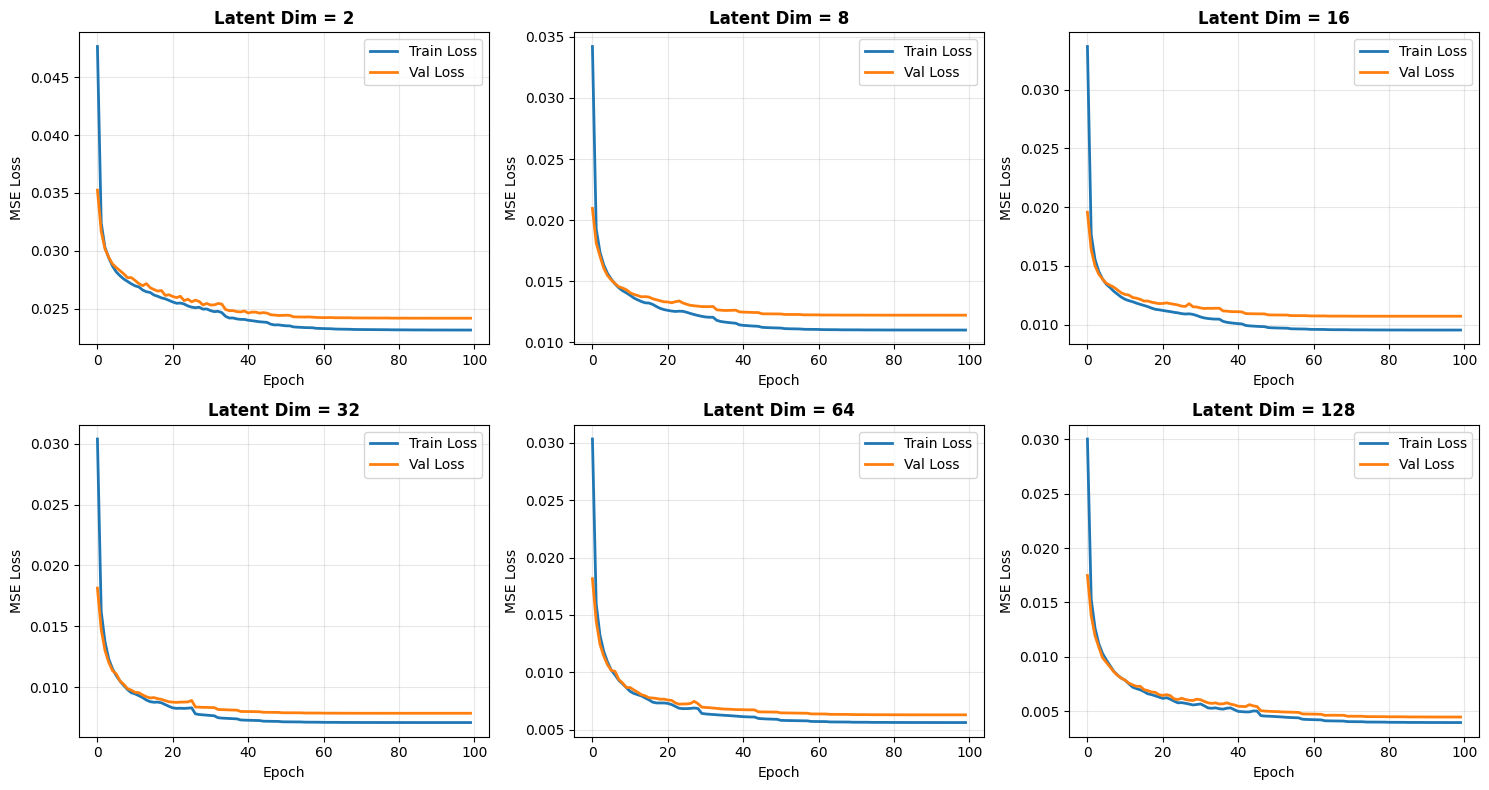

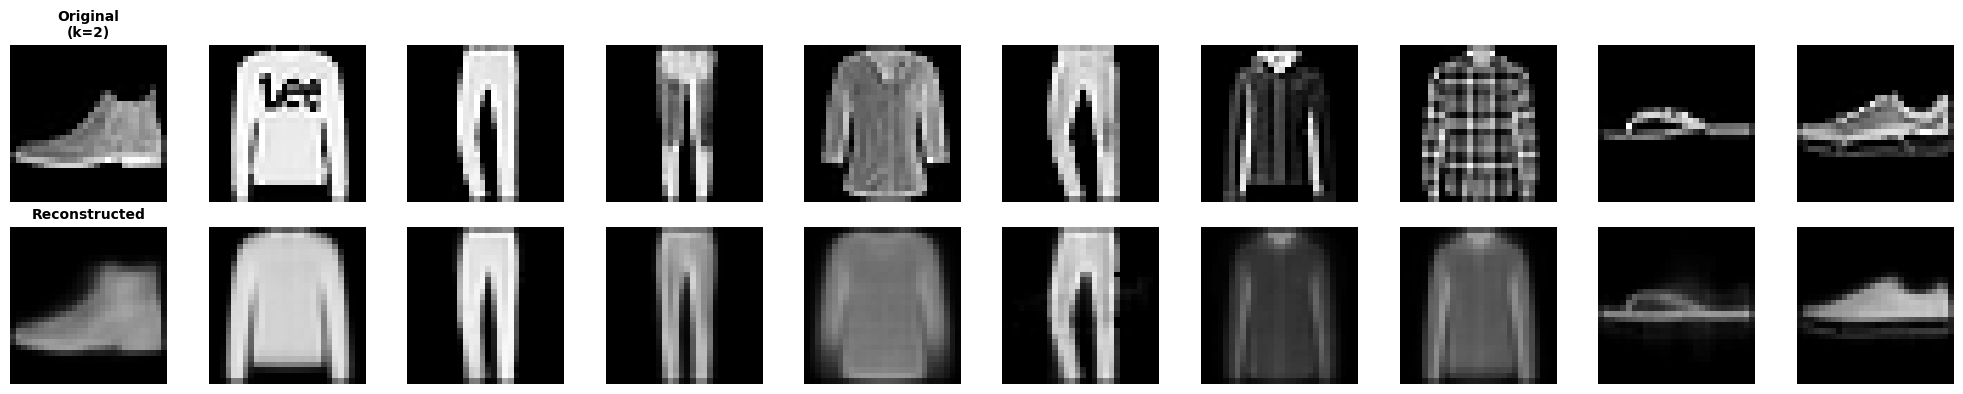

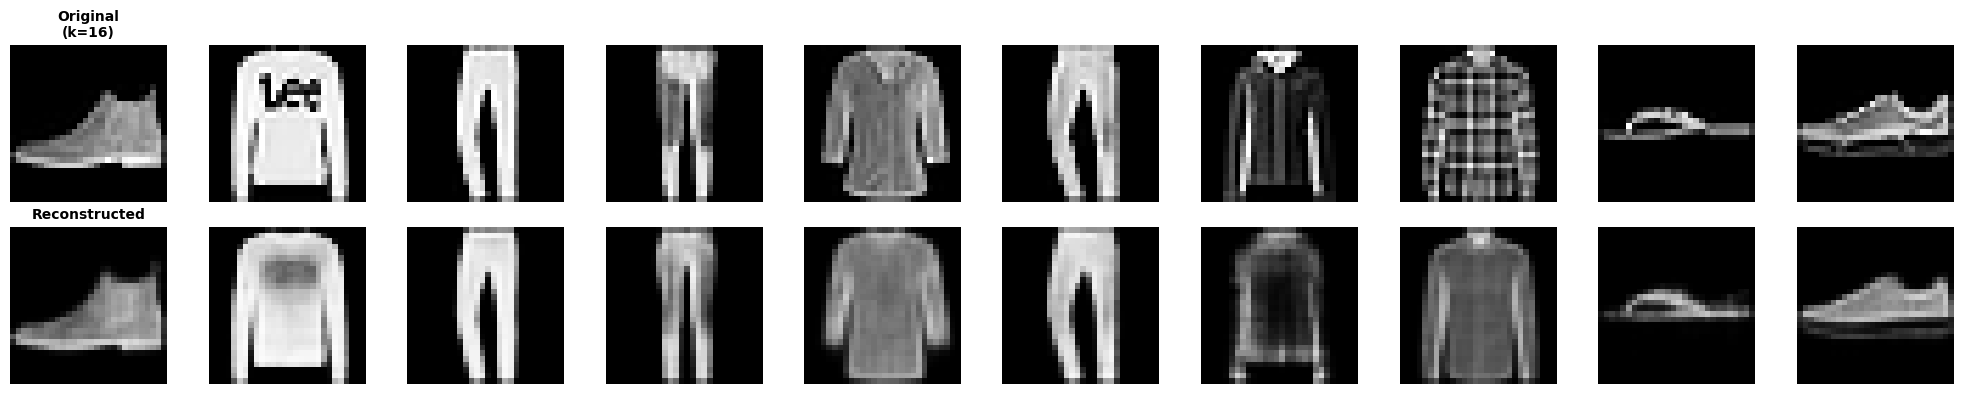

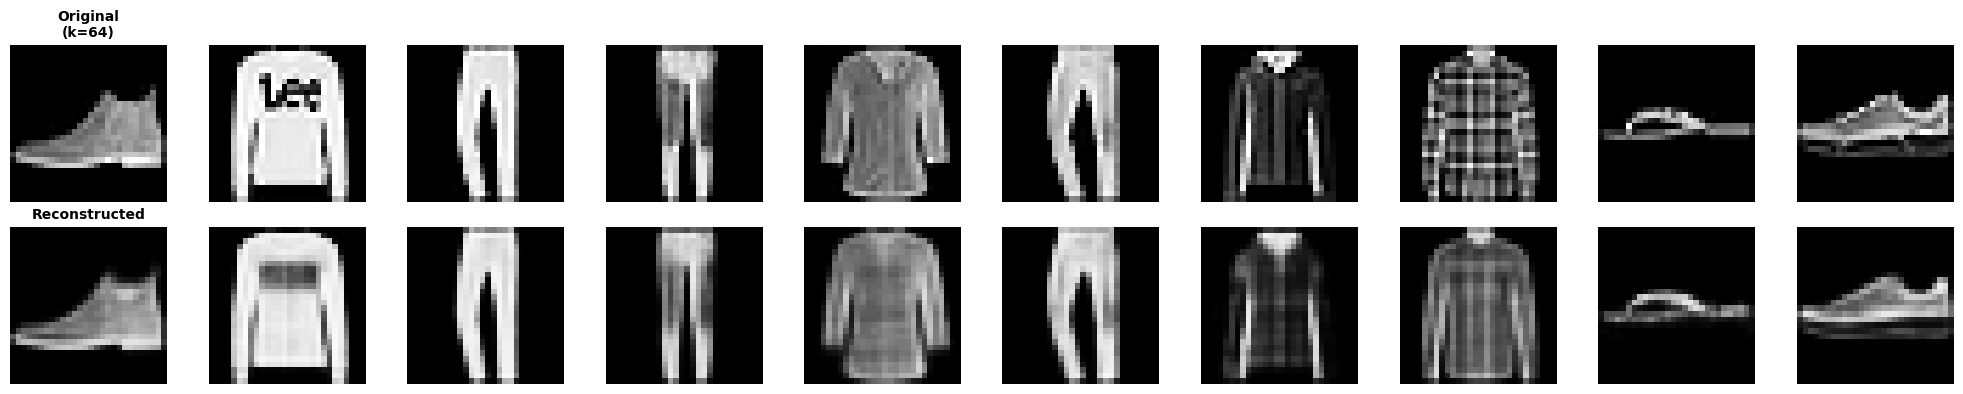

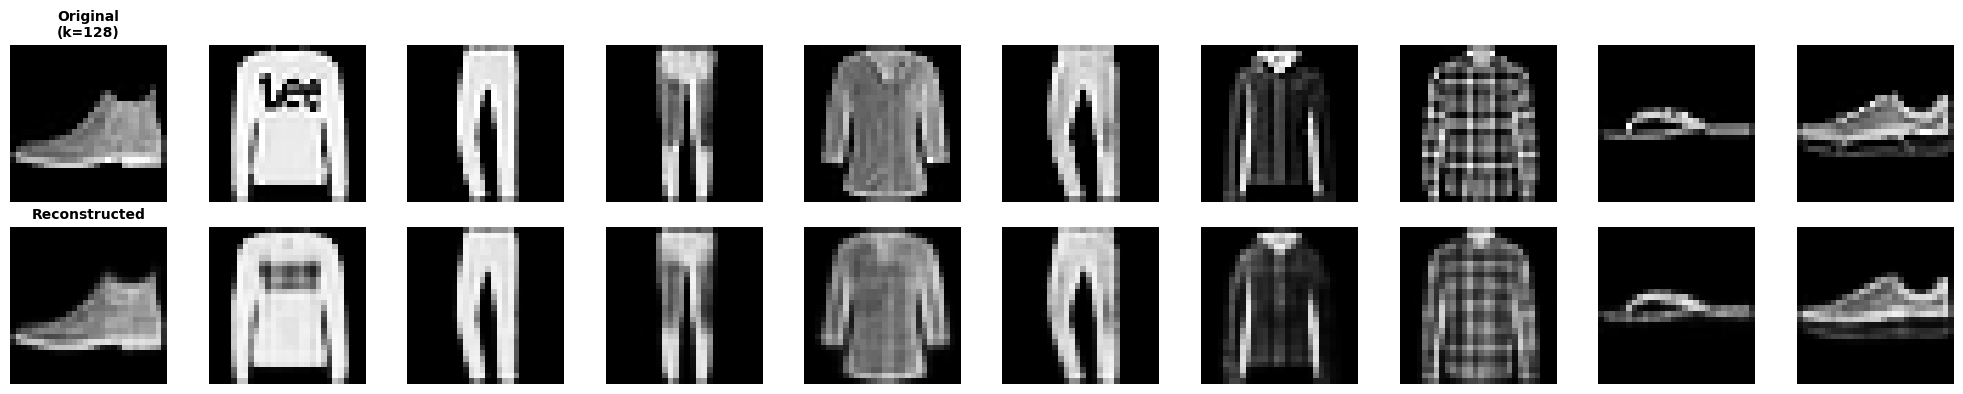

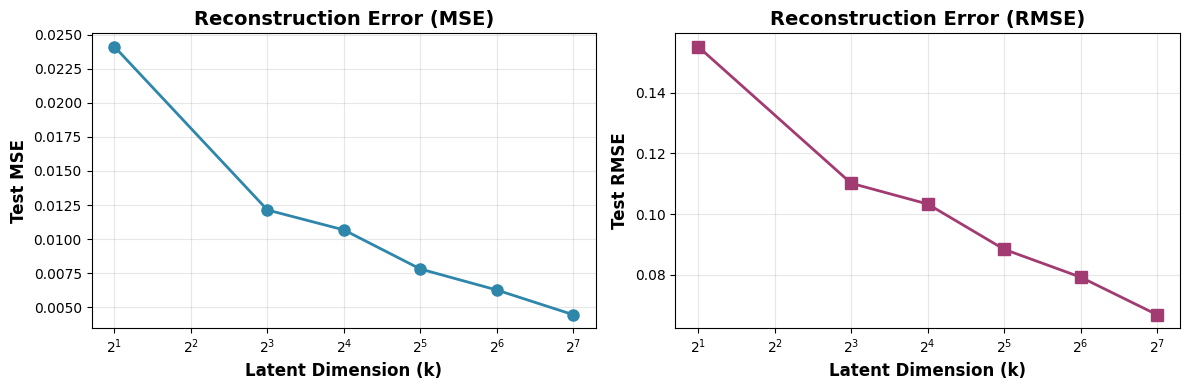

In [10]:
# =============================================================================
# 8. GENERATE VISUALIZATIONS
# =============================================================================

print("\n" + "="*60)
print("GENERATING VISUALIZATIONS")
print("="*60)

# Training curves
plot_training_history(results, HYPERPARAMETERS['latent_dims'])

# Reconstructions for each latent dimension
for latent_dim in [2, 16, 64, 128]:
    show_reconstructions(results, latent_dim, num_examples=10)

# Error comparison
plot_reconstruction_error_comparison(results, HYPERPARAMETERS['latent_dims'])



In [11]:
# =============================================================================
# 9. SUMMARY TABLE
# =============================================================================

print("\n" + "="*60)
print("AUTOENCODER RESULTS SUMMARY")
print("="*60)
print(f"{'Latent Dim':<12} {'Test MSE':<12} {'Test RMSE':<12} {'Train Time (s)':<15}")
print("-" * 60)
for k in HYPERPARAMETERS['latent_dims']:
    mse = results[k]['mse_test']
    rmse = results[k]['rmse_test']
    time_taken = results[k]['training_time']
    print(f"{k:<12} {mse:<12.6f} {rmse:<12.6f} {time_taken:<15.2f}")
print("="*60)




AUTOENCODER RESULTS SUMMARY
Latent Dim   Test MSE     Test RMSE    Train Time (s) 
------------------------------------------------------------
2            0.024109     0.155271     163.86         
8            0.012135     0.110158     166.86         
16           0.010672     0.103305     165.57         
32           0.007805     0.088347     162.71         
64           0.006264     0.079145     167.42         
128          0.004452     0.066727     168.02         


In [12]:
# =============================================================================
# 10. EXTRACT LATENT REPRESENTATIONS (for downstream tasks)
# =============================================================================

def extract_latent_features(autoencoder, x_data):
    """Extract latent representations for downstream tasks (e.g., classification)"""
    return autoencoder.encode(x_data).numpy()

# Example: Extract latent features for k=32
latent_dim_for_classification = 32
autoencoder_32 = results[latent_dim_for_classification]['model']

z_train = extract_latent_features(autoencoder_32, x_train_flat)
z_test = extract_latent_features(autoencoder_32, x_test_flat)

print(f"\nLatent features extracted (k={latent_dim_for_classification}):")
print(f"  Training set: {z_train.shape}")
print(f"  Test set: {z_test.shape}")

# Save for later use in classification experiments
np.save(f'autoencoder_latent{latent_dim_for_classification}_train.npy', z_train)
np.save(f'autoencoder_latent{latent_dim_for_classification}_test.npy', z_test)
print(f"Latent features saved to .npy files")

print("\n" + "="*60)
print("AUTOENCODER TRAINING COMPLETED!")
print("="*60)



Latent features extracted (k=32):
  Training set: (60000, 32)
  Test set: (10000, 32)
Latent features saved to .npy files

AUTOENCODER TRAINING COMPLETED!
